# practicalMixGaussC

The goal of this part of the lab is to fit a mixture of gaussians model to some multi-dimensional data. To do this, we will first generate some data from a known mixture of gaussians model and fit our own mixture of gaussians model to the generated data. The parameters from our estimated mixture of gaussians model should roughly match those of the original known model. 

You should use this template for your code and fill in the missing 
sections marked "TO DO."



In [18]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
from scipy.stats import multivariate_normal
import time
import sys

flt_min = sys.float_info.min

%matplotlib notebook

## Construct Ground Truth Mixture of Gaussians Model and Plot Some Points

Define some true parameters for our grounf truth mixture of $k$ Gaussians model. We will represent the 
mixtures of Gaussians as a python dictionary. The mean field is a $d \times k$ matrix and the cov field is a 
$d \times d \times k$ matrix.

In [19]:
mixGaussTrue = dict()
mixGaussTrue['k'] = 3
mixGaussTrue['d'] = 2
mixGaussTrue['weight'] = np.array([0.1309, 0.3966, 0.4725])
mixGaussTrue['mean'] = np.array([[ 4.0491 , 4.8597],[ 7.7578 , 1.6335],[ 11.9945, 8.9206]]).T
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2))
mixGaussTrue['cov'] = np.zeros(shape=(mixGaussTrue['d'],mixGaussTrue['d'],mixGaussTrue['k']))
mixGaussTrue['cov'][:,:,0] = np.array([[  4.2534, 0.4791], [0.4791, 0.3522]])
mixGaussTrue['cov'][:,:,1] = np.array([[  0.9729, 0.8723],[  0.8723,  2.6317]])
mixGaussTrue['cov'][:,:,2] = np.array([[  0.9886, -1.2244],[ -1.2244, 3.0187]])

**drawEMData2d**, **sampleFromDiscrete**, **getGaussian2SD**, and **drawGaussianOutline** are helper functions.

In [20]:
def sampleFromDiscrete(probDist):     
    """
    Draws a random sample from a discrete probability distribution using a rejection sampling method.  
    
    Keyword arguments:
    probDist -- discrete probability ditrubtion to sample from.
    
    Returns: 
    r -- sampled point.
    """
    nIndex = len(probDist)                                                                 
    while True:                                                                            
        #choose random index                                                               
        r=int(np.floor(np.random.uniform()*nIndex))                                        
        #choose random height                                                              
        randHeight = np.random.uniform()                                                   
        #if height is less than probability value at this point in the                     
        # histogram then select                                                            
        if randHeight<probDist[r]:                                                         
            break                                                                          
    return r                                                                               

In [21]:
def getGaussian2SD(m,s,angle1):
    """
    Find position of in xy co-ordinates at 2SD out for a certain angle.
    """
  
    if s.shape[1] == 1:
        s = diag(s)

    vec = np.array([np.cos(angle1), np.sin(angle1)])
    
    factor = 4/(vec@np.linalg.pinv(s)@vec.T)
    
    x = np.cos(angle1) * np.sqrt(factor)
    y = np.sin(angle1) * np.sqrt(factor)

    x = x + m[0]
    y = y + m[1]
                
    return x,y

In [22]:
def drawGaussianOutline(m,s,w):
    """
    Draw 2DGaussian
    """
    angleInc = 0.1    
    c = (0.9*(1-w), 0, 0)

    for cAngle in np.arange(0,2*np.pi,angleInc):         
        angle1 = cAngle
        angle2 = cAngle+angleInc
        x1, y1 = getGaussian2SD(m,s,angle1)
        x2, y2 = getGaussian2SD(m,s,angle2)
        plt.plot([x1, x2],[y1, y2],'-',linewidth=2,color=c)                 
    return

In [23]:
def drawEMData2d(data,mixGauss):
    """
    Plot the data plot the mixtures of Gaussian model, mixGauss, on top of it.
    
    Keyword arguments:
    data -- d by n matrix of data points.
    mixGauss -- dict with mixture of gaussian information.
    
    """
    #set(gcf,'Color',[1 1 1])
    plt.cla() 
    plt.plot(data[0,:],data[1,:],'k.')

    for cGauss in range(mixGauss['k']):
        drawGaussianOutline(mixGauss['mean'][:,cGauss],mixGauss['cov'][:,:,cGauss],mixGauss['weight'][cGauss])
    
    return     


In [24]:
#the goal of this routine is to evaluate a Gaussian likelihood
def calcGaussianProb(data,gaussMean,gaussCov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    nDim = data.shape[0]
    
    #TO DO (b) - fill in this routine, replace the placeholders for like with the actual equation.
    
    #replace this
    like = 1/((2*np.pi)**(nDim/2)*np.linalg.det(gaussCov)**0.5)*np.exp(-0.5*np.transpose(data-gaussMean)@np.linalg.pinv(gaussCov)@(data-gaussMean))
    return like

**TODO HERE:**

Complete the TO DO in this function before moving on.

In [25]:
def mixGaussGen(mixGauss, nData):                                                                              
    """
    Generates data from a d-dimensional mixture of Gaussians model. 
    
    Keyword arguments:
    mixGauss -- dict containing the mixture of gaussians arguments.
    nData -- number of data points to generate.
    
    Returns: 
    data -- d by nData, generated data points. 
    
    """
    # create space for output data                                                                               
    data = np.zeros(shape=(mixGauss['d'], nData))                                                                            
    # for each data point                                                                                        
    for cData in range(nData):                                                                                   
        # randomly choose Gaussian according to probability distributions                                        
        h = sampleFromDiscrete(mixGauss['weight'])                                                               
        # draw a sample from the appropriate Gaussian distribution  
        # first sample from the covariance matrix (google how to do this - it
        # will involve the numpy function np.linalg.cholesky().  Then add the mean vector
        # TO DO (f)- insert data generation code here  
        
        # numpy.linalg.cholesky() returns the Cholesky decomposition
        # find Cholesky decomposition of covariance matrix of h-th normal distribution
        L = np.linalg.cholesky(mixGauss['cov'][:,:,h])
        
        # find mean of the h-th normal distribution
        mean = mixGauss['mean'][:,h]
       
        # get samples
        data[:,cData] = mean + (L @ np.random.randn(len(data),))      
                                                                                                         
    return data

 ## <font color='blue'> Comments on code
 Every symmetric, positive definite matrix A can be decomposed by Cholesky decomposition. That is $$A = L^TL$$
(From Wikipedia)

Therefore, for a multivariate Gaussian distribution with mean $\mu$ and covariance $\sum$, we can draw a sample  $x$ from the distribution by $\mu + L z$. The data $z$ is sampled from a standard multivariate normal distribution. 


With all the helper functions complete, we can now generate and plot some points from our model. The black points are the generated data points. The circles are what the gaussians look like.

<IPython.core.display.Javascript object>


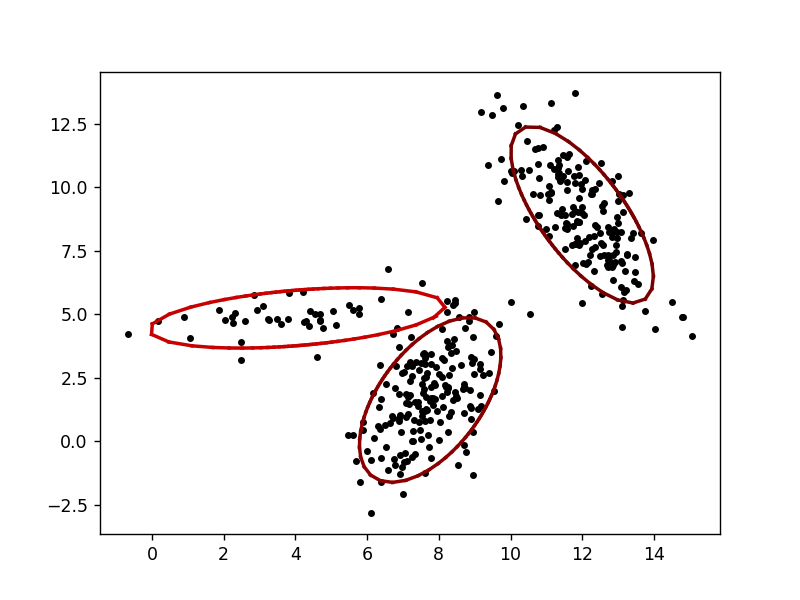

In [26]:
#define number of samples to generate
nData = 400;

#generate data from the mixture of Gaussians
#make sure you've filled in the routine above.
data = mixGaussGen(mixGaussTrue,nData)

#draw data, true Gaussians
drawEMData2d(data,mixGaussTrue)

 ## <font color='blue'> Comments on diagram
As we can see from the diagram, the data generated are approximately fit the two gaussian distribution. (How the data sampled from the gaussian distribution is explained above).


## Estimate MoG using the E-M Algorithm
Here we want to use the E-M algorithm to fit a MoG model to our data points. 

**TODO HERE:** 

Fill out the missing parts below. 

The log likelihood is taken since the raw likelihood value could be too small for our machine's percision.

In [27]:

def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]                                                                      
        # TO DO - calculate likelihood of this data point under mixture of                         
        # Gaussians model. Replace this                                                                
        like = 0
        for k in range(mixGaussEst['k']):
            like += mixGaussEst['weight'][k]*calcGaussianProb(thisData,mixGaussEst['mean'][:,k],mixGaussEst['cov'][:,:,k])

        # add to total log like                                                                        
        logLike = logLike + np.log(like)   
                                                                                                       
    return  np.asscalar(logLike)                                                                         
                                                                                                       

 ## <font color='blue'> Comments on code
 The calculated weight to scale the probability of the data in each Gaussian distribution. The likelihood is the sum of the weighted probability.

**TODO HERE:** 

Fill out the missing parts below. 

In [58]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape


    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        

    # calculate current likelihood
    # TO DO - fill in this routine
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    nIter = 20;

    logLikeVec = np.zeros(shape=(2 * nIter))
    boundVec = np.zeros(shape=(2 * nIter))

    fig, ax = plt.subplots(1, 1)

    for cIter in range(nIter):

        # ===================== =====================
        # Expectation step
        # ===================== =====================

        for cData in range(nData):
            # TO DO (g) : fill in column of 'hidden' - calculate posterior probability that
            # this data point came from each of the Gaussians
            # replace this:
            
            # data is a d x 1 matrix
            thisData = data[:, cData] 
              
            
            for i in range(mixGaussEst['k']):
                postHidden[i, cData] = mixGaussEst['weight'][i]*calcGaussianProb(thisData,mixGaussEst['mean'][:,i],mixGaussEst['cov'][:,:,i])
 
           
            postHidden[:, cData] = postHidden[:, cData]/np.sum(postHidden[:,cData])

        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            # TO DO (h):  Update weighting parameters mixGauss.weight based on the total
            # posterior probability associated with each Gaussian. Replace this:
            mixGaussEst['weight'][cGauss] = np.sum(postHidden[cGauss,:])/np.sum(postHidden)

            # TO DO (i):  Update mean parameters mixGauss.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.  Replace this:
            # postHidden[cGauss,:] -> postHidden for each data at k = cGauss
            # data -> d x n matrix
            # mixGaussEst['mean'][:,cGauss] -> dx1 
            # we need to consider all the dimension of x 
            # calculate postHidden * data at dimension_i for each dimension 
            mixGaussEst['mean'][:,cGauss] = (postHidden[cGauss,:].reshape(1,nData) @ np.transpose(data))/ np.sum(postHidden[cGauss,:])
            
            
            # TO DO (j):  Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            # data is a d x n matrix
            # mixGaussEst['cov'][:,:,cGauss] -> dxd
            # Covariance Matrix  
            # mij = cov(data_in_dimension_i, data_in_dimension_j)
            # Covarience between two set of data
            # cov= mij 
            # First, for each dimension of data, calculate the value of data_ith_dimension - mu_i_th_dimension
            dataMinusMu = np.zeros((nDims,nData)) # dxn
            for d in range(nDims):
                dataMinusMu[d,:] = data[d,:]- mixGaussEst['mean'][d,cGauss]
            sumDist = np.zeros((nDims,nDims))
            for i in range(nData):
                sumDist += postHidden[cGauss,i]*dataMinusMu[:,i].reshape(nDims,1)@np.transpose(dataMinusMu[:,i].reshape(nDims,1))

            # Normalize
            mixGaussEst['cov'][:,:,cGauss] = sumDist / np.sum(postHidden[cGauss,:]) 
            
            # avoid unblanced gaussian mixture
            if cGauss > 0:
                for index in range(cGauss):
                    # for the condition that one gaussian only fits a few data
                    for row in range(mixGaussEst['cov'][:,:,index].shape[0]):
                        for col in range(mixGaussEst['cov'][:,:,index].shape[1]):
                        
                            if mixGaussEst['cov'][row,col,index] / mixGaussEst['cov'][row,col,cGauss]>40 :
                                    print('Re-initialize cov!')
                                    #try sth smaller
                                    mixGaussEst['cov'][:,:,index] = mixGaussEst['cov'][:,:,index]*0.7
                                    #try sth bigger
                                    mixGaussEst['cov'][:,:,cGauss] = mixGaussEst['cov'][:,:,cGauss]*1.2
                                    
                                    
                            if mixGaussEst['cov'][row,col,cGauss] / mixGaussEst['cov'][row,col,index] > 40:
                                    print('Re-initialize cov!')
                                    #try sth smaller
                                    mixGaussEst['cov'][:,:,cGauss] = mixGaussEst['cov'][:,:,cGauss]*0.7
                                    #try sth bigger
                                    mixGaussEst['cov'][:,:,index] = mixGaussEst['cov'][:,:,index]*1.2
                                   

                            
    
        # draw the new solution
        drawEMData2d(data, mixGaussEst)
        time.sleep(0.7)
        fig.canvas.draw()

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))

    return mixGaussEst

 ## <font color='blue'> Comments on code
E-step maximizes bound with respect to the probability distribution $qi(hi)$.
M-step maximizes bound with respect to parameters.
    
As there is a condition that one or more initial gaussian model only fit a few data, the other Gaussian models may try their best to fit the rest of data. The model will not converge very well at last under this condition. Due to the condition that high covariance always relates to the condition that one gaussian tries to fit the rest of data, I added a test after calculating the covariance.  If the covariance of one gaussian model is much higher when it compared to the other ones, the system will re-initialize it.

### Time to put it all together!

Make sure you've filled all the TO DOs above! 

Log Likelihood Iter 0 : -7905.322



<IPython.core.display.Javascript object>


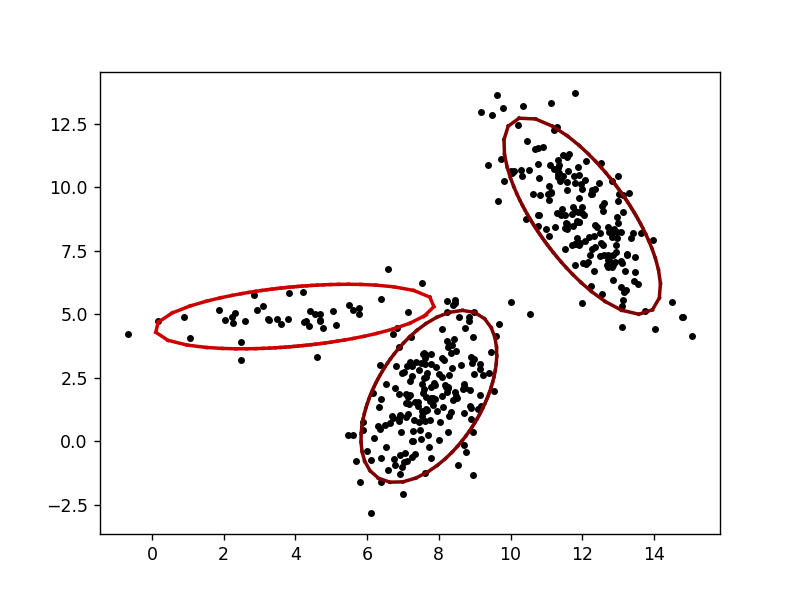

Log Likelihood After Iter 0 : -1959.803

Re-initialize!
Re-initialize!
Log Likelihood After Iter 1 : -1932.025

Re-initialize!
Re-initialize!
Log Likelihood After Iter 2 : -1905.315

Re-initialize!
Re-initialize!
Log Likelihood After Iter 3 : -1891.246

Re-initialize!
Log Likelihood After Iter 4 : -1865.799

Log Likelihood After Iter 5 : -1824.552

Log Likelihood After Iter 6 : -1748.602

Log Likelihood After Iter 7 : -1659.421

Log Likelihood After Iter 8 : -1644.564

Log Likelihood After Iter 9 : -1644.480

Log Likelihood After Iter 10 : -1644.477

Log Likelihood After Iter 11 : -1644.476

Log Likelihood After Iter 12 : -1644.476

Log Likelihood After Iter 13 : -1644.475

Log Likelihood After Iter 14 : -1644.475

Log Likelihood After Iter 15 : -1644.475

Log Likelihood After Iter 16 : -1644.475

Log Likelihood After Iter 17 : -1644.475

Log Likelihood After Iter 18 : -1644.475

Log Likelihood After Iter 19 : -1644.475



In [61]:
#define number of components to estimate
nGaussEst = 3

#fit mixture of Gaussians (Pretend someone handed you some data. Now what?)
#TO DO fill in this routine (below)
mixGaussEst = fitMixGauss(data,nGaussEst);



 ## <font color='blue'> Comments on diagram
As we can see from the result, the gaussians fit the data very well.

At each E step, the system signs points to each Gaussian model according to the probobility of each point.
At each M step, the system updates the parameters like mean and covariance based on current assignment to maximize fitting.
    
Furthermore, after adding the test mentioned above, the system will try lower convariance for the gaussian with much high covarience and try higher covariance for the gaussian with much low covariance. Therefore, the models of Gaussian always converge at last.

In [57]:
mixGaussEst

{'d': 2,
 'k': 3,
 'weight': array([0.07942523, 0.75427218, 0.16630259]),
 'mean': array([[6.25468822, 9.6069963 , 8.78303884],
        [8.46175628, 4.24188954, 8.33267928]]),
 'cov': array([[[17.18614782,  6.26496099, 11.0317963 ],
         [14.81827631,  7.16658421,  8.44657132]],
 
        [[14.81827631,  7.16658421,  8.44657132],
         [14.21607267, 11.57597409,  7.29834916]]])}